In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import xgboost
from tqdm import tqdm_notebook as progress
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from IPython.display import display, HTML # pretty print

In [3]:
file_location = "/mnt/share/Competition/creditcard"
train_csv = "/train.csv"
test_csv = "/test.csv"
submission_csv = "/submission.csv"

train = pd.read_csv(file_location + train_csv)
test = pd.read_csv(file_location + test_csv)

In [4]:
display(train.head())
display(test.head())

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01,00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01,01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01,01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01,17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01,18:48:53,6a722ce674,125,NaN,0,0


In [5]:
days_to_one = OneHotEncoder()

def DataPreprocessing(data, test = "train"):
    global days_to_one
    data.drop("card_id", axis = 1, inplace = True)
    data.drop("time", axis = 1, inplace = True)
    days = None
    if test == "train":
        days = pd.DataFrame(days_to_one.fit_transform(data.loc[:, ["days_of_week"]]).toarray())
    else:
        days = pd.DataFrame(days_to_one.transform(data.loc[:, ["days_of_week"]]).toarray())
    data = pd.concat([data, days], axis = 1)
    data.drop("days_of_week", axis = 1, inplace = True)
    display(data.head())
    return data

In [6]:
train = DataPreprocessing(train)
test = DataPreprocessing(test, "test")

,store_id,date,amount,installments,holyday,0,1,2,3,4,5,6
0,0,2016-12-14,5,NaN,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,2016-12-14,-5,NaN,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,2016-12-19,144,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2016-12-19,66,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2016-12-19,24,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,store_id,date,amount,installments,holyday,0,1,2,3,4,5,6
0,0,2016-08-01,125,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2016-08-01,90,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2016-08-01,150,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2016-08-01,362,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2016-08-01,125,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train = train.values
test = test.values

In [8]:
def DataPreprocessing(data, test = "train"):
    firstdate = np.datetime64("2018-03-31")
    lastdate = np.datetime64("2018-07-09")
    ratio = (np.datetime64("2018-07-31") - firstdate).astype(np.float64)
    ratio = (lastdate - firstdate).astype(np.float64) / ratio
    
    processed_x, processed_y = list(), list()
    onestore_x = [0 for _ in range(16)]
    onestore_y = [0]
    onestore_x[2] = 1e10
    for row in progress(range(data.shape[0])):
        # time processing
        date = np.datetime64(data[row][1])
        # installments processing
        if pd.isna(data[row][3]):
            data[row][3] = 1
        if date <= firstdate:
            update_x(data[row], onestore_x)
        else:
            update_y(data[row][2], onestore_y)
        if row == data.shape[0] - 1 or data[row + 1][0] != data[row][0]:
            if test == "test":
                revalue(onestore_x)
                processed_x.append(onestore_x)
            elif onestore_x[0] - onestore_x[1] > 0 and onestore_y[0] > 0 and onestore_x[4] > 0:
                revalue(onestore_x)
                processed_x.append(onestore_x)
                onestore_y[0] *= ratio
                processed_y.append(onestore_y)                
            onestore_x = [0 for _ in range(16)]
            onestore_y = [0]
            onestore_x[2] = 1e10
    return np.array(processed_x).astype(np.float64), np.array(processed_y).astype(np.float64)

In [9]:
def update_x(data, storage):
    for idx in range(len(storage)):
        if idx == 0:
            storage[idx] += 1
        elif idx == 1:
            if data[2] < 0:
                storage[idx] += 1
        elif idx == 2:
            storage[idx] = min(storage[idx], np.datetime64(data[1]).astype(np.float64))
        elif idx == 3:
            storage[idx] = max(storage[idx], np.datetime64(data[1]).astype(np.float64))
        elif idx == 4 or idx == 5 or idx == 6:
            storage[idx] += data[2]
        else:
            storage[idx] += data[idx - 4]

def update_y(data, storage):
    storage[0] += data
    
def revalue(storage):
    firstdate = np.datetime64("2018-03-31").astype(np.float64)
    storage[5] /= storage[0] - storage[1]
    storage[6] /= firstdate - storage[2] + 1
    storage[6] *= 100
    for idx in range(7, len(storage)):
        storage[idx] /= storage[0]

In [10]:
X_train, y_train = DataPreprocessing(train)
X_test, _ = DataPreprocessing(test, "test")

In [11]:
col_name = ["counts", 'cancel', 'start', 'end', 'price_sum', 'price_per_counts', 'price_per_day', 'installment', 'holyday',\
            '0', '1', '2', '3', '4', '5', '6']
X_train = pd.DataFrame(X_train, columns=col_name)
X_test = pd.DataFrame(X_test, columns=col_name)
display(X_train.head())
display(X_test.head())

,counts,cancel,start,end,price_sum,price_per_counts,price_per_day,installment,holyday,0,1,2,3,4,5,6
0,54313.0,479.0,17149.0,17621.0,4174544.0,77.544749,882567.441860,1.005781,0.055254,0.135713,0.139377,0.141808,0.142176,0.142599,0.147607,0.150719
1,35.0,0.0,17156.0,17602.0,120650.0,3447.142857,25890.557940,2.542857,0.000000,0.371429,0.257143,0.228571,0.085714,0.057143,0.000000,0.000000
2,14237.0,47.0,17014.0,17621.0,1379067.0,97.185835,226820.230263,1.000000,0.024092,0.133666,0.167662,0.163166,0.158039,0.164993,0.111119,0.101356
3,315.0,2.0,17016.0,17613.0,49164.0,157.073482,8112.871287,1.000000,0.006349,0.171429,0.190476,0.158730,0.180952,0.282540,0.015873,0.000000
4,1428.0,4.0,17324.0,17621.0,192402.0,135.113764,64564.429530,1.000000,0.022409,0.138655,0.086835,0.129552,0.146359,0.158964,0.161765,0.177871


,counts,cancel,start,end,price_sum,price_per_counts,price_per_day,installment,holyday,0,1,2,3,4,5,6
0,4215.0,14.0,17014.0,17621.0,638257.0,151.929779,104976.480263,1.000237,0.047450,0.119098,0.128826,0.120996,0.124318,0.162515,0.179122,0.165125
1,435.0,14.0,17015.0,17620.0,427806.0,1016.166271,70478.747941,1.314943,0.029885,0.114943,0.190805,0.124138,0.165517,0.103448,0.195402,0.105747
2,655.0,8.0,17014.0,17620.0,288211.0,445.457496,47403.125000,1.981679,0.022901,0.140458,0.163359,0.187786,0.151145,0.178626,0.151145,0.027481
3,2019.0,5.0,17014.0,17621.0,229284.0,113.845084,37711.184211,1.000000,0.052997,0.113918,0.138683,0.109460,0.107479,0.165428,0.178801,0.186231
4,4089.0,21.0,17014.0,17621.0,158572.0,38.980334,26080.921053,1.000000,0.027146,0.169235,0.169724,0.162876,0.164832,0.159941,0.081927,0.091465


In [12]:
X_scaler = MinMaxScaler(feature_range = (0, 1))

X_train = X_scaler.fit_transform(X_train)
y_scaler = X_scaler.data_max_[6]

y_train = np.array(y_train / y_scaler).reshape((-1, 1))
X_test = X_scaler.transform(X_test)

X_train = np.concatenate((X_train, y_train), axis = 1)
X_train = pd.DataFrame(X_train, columns=col_name + ['y'])
X_test = pd.DataFrame(X_test, columns=col_name)

display(X_train.head())
display(X_test.head())

,counts,cancel,start,end,price_sum,price_per_counts,price_per_day,installment,holyday,0,1,2,3,4,5,6,y
0,1.000000,0.269252,0.222405,1.0000,0.447112,0.003055,0.412441,0.000649,0.174673,0.135713,0.139377,0.141808,0.142176,0.142599,0.147607,0.262120,0.406059
1,0.000626,0.000000,0.233937,0.9525,0.012920,0.164749,0.012096,0.173178,0.000000,0.371429,0.257143,0.228571,0.085714,0.057143,0.000000,0.000000,0.010457
2,0.262115,0.026419,0.000000,1.0000,0.147702,0.003997,0.105995,0.000000,0.076162,0.133666,0.167662,0.163166,0.158039,0.164993,0.111119,0.176271,0.090397
3,0.005781,0.001124,0.003295,0.9800,0.005263,0.006871,0.003788,0.000000,0.020072,0.171429,0.190476,0.158730,0.180952,0.282540,0.015873,0.000000,0.005216
4,0.026274,0.002248,0.510708,1.0000,0.020605,0.005817,0.030169,0.000000,0.070841,0.138655,0.086835,0.129552,0.146359,0.158964,0.161765,0.309341,0.029843


,counts,cancel,start,end,price_sum,price_per_counts,price_per_day,installment,holyday,0,1,2,3,4,5,6
0,0.077589,0.007870,0.000000,1.0000,0.068358,0.006624,0.049054,0.000027,0.150002,0.119098,0.128826,0.120996,0.124318,0.162515,0.179122,0.287173
1,0.007991,0.007870,0.001647,0.9975,0.045818,0.048096,0.032933,0.035351,0.094475,0.114943,0.190805,0.124138,0.165517,0.103448,0.195402,0.183908
2,0.012042,0.004497,0.000000,0.9975,0.030866,0.020710,0.022149,0.110189,0.072396,0.140458,0.163359,0.187786,0.151145,0.178626,0.151145,0.047793
3,0.037156,0.002811,0.000000,1.0000,0.024555,0.004797,0.017620,0.000000,0.167537,0.113918,0.138683,0.109460,0.107479,0.165428,0.178801,0.323880
4,0.075269,0.011804,0.000000,1.0000,0.016981,0.001204,0.012185,0.000000,0.085816,0.169235,0.169724,0.162876,0.164832,0.159941,0.081927,0.159069


In [13]:
X_train.drop(644, inplace = True)

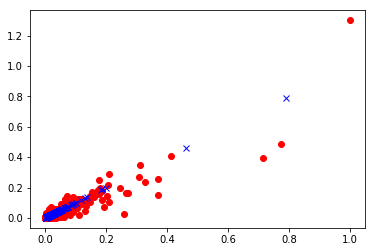

In [14]:
#plt.plot(X_train.price_per_day, X_train.y, 'ro')
plt.plot(X_train.price_per_day, X_train.y, 'ro')
plt.plot(X_test.price_per_day, X_test.price_per_day, 'bx')


plt.show()

In [15]:
y_train = X_train.y

X_train.drop(columns=['y'], inplace=True)
display(X_train.head())
display(y_train.head())
print(X_train.shape, y_train.shape)

,counts,cancel,start,end,price_sum,price_per_counts,price_per_day,installment,holyday,0,1,2,3,4,5,6
0,1.000000,0.269252,0.222405,1.0000,0.447112,0.003055,0.412441,0.000649,0.174673,0.135713,0.139377,0.141808,0.142176,0.142599,0.147607,0.262120
1,0.000626,0.000000,0.233937,0.9525,0.012920,0.164749,0.012096,0.173178,0.000000,0.371429,0.257143,0.228571,0.085714,0.057143,0.000000,0.000000
2,0.262115,0.026419,0.000000,1.0000,0.147702,0.003997,0.105995,0.000000,0.076162,0.133666,0.167662,0.163166,0.158039,0.164993,0.111119,0.176271
3,0.005781,0.001124,0.003295,0.9800,0.005263,0.006871,0.003788,0.000000,0.020072,0.171429,0.190476,0.158730,0.180952,0.282540,0.015873,0.000000
4,0.026274,0.002248,0.510708,1.0000,0.020605,0.005817,0.030169,0.000000,0.070841,0.138655,0.086835,0.129552,0.146359,0.158964,0.161765,0.309341


0    0.406059
1    0.010457
2    0.090397
3    0.005216
4    0.029843
Name: y, dtype: float64

(1543, 16) (1543,)


In [16]:
'''
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

W = dict()
b = dict()
W[0] = tf.Variable(tf.random_normal([16, 8]))
b[0] = tf.Variable(tf.random_normal([8]))
y1 = tf.nn.relu(tf.matmul(X, W[0]) + b[0])

W[1] = tf.Variable(tf.random_normal([8, 1]))
b[1] = tf.Variable(tf.random_normal([8]))
Y_hat = tf.nn.relu(tf.matmul(y1, W[1]) + b[1])

hypothesis = ((Y - Y_hat + tf.abs(Y - Y_hat)) * (Y_hat * 13 / 365) + \
              (Y - Y_hat - tf.abs(Y - Y_hat)) * (Y - Y_hat))
hypothesis /= 2 * (Y_hat - Y) + 1e-8

cost = tf.reduce_mean(hypothesis)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(5000):
    _, cost_val = sess.run([train_op, cost], feed_dict={X: X_train, Y: y_train})
    if step % 1000 == 0:
        print(step, cost_val)

'''

'\nX = tf.placeholder(tf.float32)\nY = tf.placeholder(tf.float32)\n\nW = dict()\nb = dict()\nW[0] = tf.Variable(tf.random_normal([16, 8]))\nb[0] = tf.Variable(tf.random_normal([8]))\ny1 = tf.nn.relu(tf.matmul(X, W[0]) + b[0])\n\nW[1] = tf.Variable(tf.random_normal([8, 1]))\nb[1] = tf.Variable(tf.random_normal([8]))\nY_hat = tf.nn.relu(tf.matmul(y1, W[1]) + b[1])\n\nhypothesis = ((Y - Y_hat + tf.abs(Y - Y_hat)) * (Y_hat * 13 / 365) +               (Y - Y_hat - tf.abs(Y - Y_hat)) * (Y - Y_hat))\nhypothesis /= 2 * (Y_hat - Y) + 1e-8\n\ncost = tf.reduce_mean(hypothesis)\n\noptimizer = tf.train.AdamOptimizer(learning_rate=0.01)\ntrain_op = optimizer.minimize(cost)\n\nsess = tf.Session()\nsess.run(tf.global_variables_initializer())\n\nfor step in range(5000):\n    _, cost_val = sess.run([train_op, cost], feed_dict={X: X_train, Y: y_train})\n    if step % 1000 == 0:\n        print(step, cost_val)\n\n'

In [17]:
'''
print("\n=== Test ===")
base = np.arange(0, max(y_train), 1000)
a = sess.run(Y_hat, feed_dict={X: X_train})
b = sess.run(Y_hat, feed_dict={X: X_cross})
plt.plot(a, y_train, 'bo')
plt.plot(b, y_cross, 'ro')
plt.plot(base, base, 'go')
plt.show()
'''

'\nprint("\n=== Test ===")\nbase = np.arange(0, max(y_train), 1000)\na = sess.run(Y_hat, feed_dict={X: X_train})\nb = sess.run(Y_hat, feed_dict={X: X_cross})\nplt.plot(a, y_train, \'bo\')\nplt.plot(b, y_cross, \'ro\')\nplt.plot(base, base, \'go\')\nplt.show()\n'

In [18]:
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test)

In [28]:
print(X_train.shape)
print(y_train.shape)

(1543, 16)
(1543,)


In [56]:
def custom_objective(y_hat, dtrain):
    grad = y_hat.copy()
    hess = y_hat.copy()
    grad *= 0
    hess *= 0
    temp = y_hat < 0.0004
#    y_hat[y_hat < 0] = 0
    y = dtrain.get_label()
    grad[y >= y_hat] += (13 / 365) * y_hat[y >= y_hat]
    grad[y < y_hat] += y[y < y_hat] - y_hat[y < y_hat]
    
    grad[temp] = 0
    
    hess[y >= y_hat] += (13 / 365)
    hess[y < y_hat] -= 1
    
    hess[temp] = 0
    
    return -grad, -hess

In [57]:
def custom_eval(y_hat, y):
    #higher *= 13 / 365
    y_hat[y_hat < 0.0004] = 0.0004
    y_bigger = np.sum(y_hat[y >= y_hat]) * 13 / 365
    y_hat_bigger = np.sum(y[y < y_hat] - y_hat[y < y_hat])
    return (y_bigger + y_hat_bigger) / y.shape[0]

In [58]:
xgb = dict()

depth = np.array([4, 5, 6, 7])
depth += -1

model_counts = len(depth)

for i in range(model_counts):
    param = {'silent': 1, 'max_depth': depth[i], 'eta': 0.1, 'colsample_bylevel': 0.5,\
             'subsample': 0.5}
    xgb[i] = xgboost.train(param, dtrain, 160, obj = custom_objective, feval = custom_eval)
    value = np.array(xgb[i].predict(dtrain))
    print("%dst model" % i)
    print("train =", custom_eval(value, y_train))

0st model
train = 0.00029037564821816924
1st model
train = 0.00033443962272177016
2st model
train = 0.00038956245002254243
3st model
train = 0.0003732588162154584


In [63]:
value = np.array(xgb[0].predict(dtrain))
value *= 0

for i in range(model_counts):
    valuei = np.array(xgb[i].predict(dtrain))
    valuei[valuei < 0.0004] = 0.0004
    value += valuei

    
value *= 0.98
value /= model_counts
print(custom_eval(value, y_train))


0.00034163138038215135


0.9708360337005832


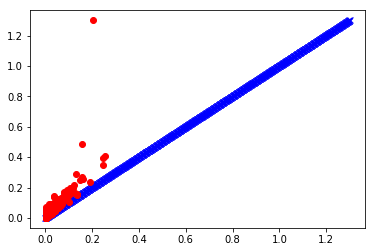

In [64]:
#target_X = np.arange(0, max(amount_check), max(amount_check) / 10000)
#target_y = [sess.run(Y_hat, feed_dict={X:x}) for x in target_X]


base = np.arange(0, max(y_train), max(y_train) / 1000)
plt.plot(base, base, 'bx')
plt.plot(value, y_train, 'ro')
#plt.plot(value, X_train.price_per_day, 'yx')

print(np.mean(y_train > value))
plt.show()

In [65]:
res = np.array([xgb[0].predict(dtest)]).T
res *= 0
for i in range(model_counts):
    res1 = np.array([xgb[i].predict(dtest)]).T
    res1[res1 < 0.0004] = 0.0004
    res += res1
res /= model_counts
res *= 0.98
print(res[:5])
res = res * y_scaler
print(res[:5])


[[0.02137593]
 [0.01343062]
 [0.00475393]
 [0.0033713 ]
 [0.00336745]]
[[45741.383 ]
 [28739.584 ]
 [10172.715 ]
 [ 7214.0977]
 [ 7205.8447]]


In [66]:
def submit(file_name, submit_data):
    result = pd.read_csv(file_name)
    result["total_sales"] = submit_data
    display(result.head())
    result.to_csv(file_name)

In [67]:
submit(file_location + submission_csv, res)

,store_id,total_sales
0,0,45741.382812
1,1,28739.583984
2,2,10172.714844
3,3,7214.097656
4,4,7205.844727


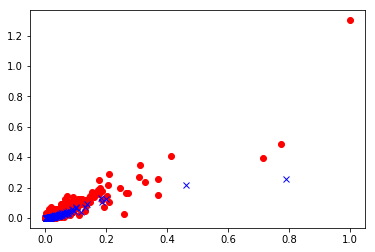

In [68]:
plt.plot(X_train.price_per_day, y_train, 'ro')
plt.plot(X_test.price_per_day, res / y_scaler, 'bx')


plt.show()
